## 1. LSTM
LSTM(Long Short-Term Memory)은 RNN의 장기 의존성 문제를 해결하기 위해 고안된 모델입니다. LSTM은 셀 상태(cell state)와 3개의 게이트(입력 게이트, 출력 게이트, 망각 게이트)를 사용하여 중요한 정보를 오랫동안 저장하고 불필요한 정보를 제거하는 구조를 갖추고 있습니다. 망각 게이트는 이전 셀 상태에서 필요 없는 정보를 삭제하고, 입력 게이트는 새로운 정보를 저장하며, 출력 게이트는 최종 출력을 결정합니다. 이러한 구조 덕분에 LSTM은 장기 시퀀스를 다루는 자연어 처리, 음성 인식, 시계열 예측 등의 다양한 분야에서 효과적으로 사용됩니다. 하지만 구조가 복잡하여 계산량이 많고, 학습 시간이 오래 걸린다는 단점이 있습니다.

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2F0T4cT%2FbtrrY50Subw%2FAAAAAAAAAAAAAAAAAAAAACXwMhXq2Zp5P-LuzxpcJMN0PklRwYhdBq_6RSh-EOBA%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1756652399%26allow_ip%3D%26allow_referer%3D%26signature%3D%252BjrqVstpExHeBAU92uZhTV6DAXg%253D" width=700>
<img src="https://blog.kakaocdn.net/dna/bLeD3a/btsP4VhoAim/AAAAAAAAAAAAAAAAAAAAAFKPB-zMUftY13DpIiLI7Pk6MnCILv3zsUGNtUs4Ly3m/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1756652399&allow_ip=&allow_referer=&signature=Z1cLMS%2BdcXrGIBgwevUMrO4InUs%3D" width=700>


### 1. 망각게이트
망각 게이트는 이전 정보를 얼마나 유지할지, 혹은 버릴지를 결정한다. 즉, 불필요한 정보는 삭제하고, 중요한 정보만 남긴다. 시그모이드 함수로 변환한 값을 출력한다.

> 시그모이드 함수를 사용하여 1에 가까우면 유지하고 0에 가까우면 버리는 방식이다.

<img src="https://blog.kakaocdn.net/dna/cpP7aq/btsP4YSPpuA/AAAAAAAAAAAAAAAAAAAAACztO4bP9aL6uhzTASF6-aVIZ3O0As4opxPVLAB57ve9/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1756652399&allow_ip=&allow_referer=&signature=IhH%2FXt8un7bSEI4zKEYGVnLERW4%3D" width=700>


### 2. 입력게이트
입력 게이트는 현재 입력된 정보를 기억할지 결정한다. 즉 새로운 정보를 LSTM에 추가할지 조절한다. tanh를 사용하여 새롭게 저장할 정보의 후보값을 저장한다.

<img src="https://blog.kakaocdn.net/dna/dhuDAQ/btsP6eHjYy6/AAAAAAAAAAAAAAAAAAAAAECsUTJ4hoqhD30HrKVooYDEqtfSnDt_S8SX-A5_ebvX/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1756652399&allow_ip=&allow_referer=&signature=ZVZEZbQKe2DY4JPyQ3dv8GclnwE%3D" width=700>


### 3. 출력게이트
출력 게이트는 현재 상태에서 어떤 정보를 출력할지를 결정한다. 즉, LSTM이 다음 타임스텝으로 넘겨줄 정보를 조절한다. tanh 함수를 사용하여 변환한 후 정보를 곱해 최종 은닉 상태를 만든다.

<img src="https://blog.kakaocdn.net/dna/dGMK91/btsP6TbM5XX/AAAAAAAAAAAAAAAAAAAAAI850a914C_WlOa18ZxqDno1PcGDkGNweDqVYNka3mFw/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1756652399&allow_ip=&allow_referer=&signature=jZML%2FwoHjQ4V27r5cZGvlRmw%2F4A%3D" width=700>

In [2]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

mecab-ko is already installed
mecab-ko-dic is already installed
<string>:1: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
mecab-python is already installed
Done.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import re
from konlpy.tag import Mecab
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
# 데이터 로드
url = 'https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt'
data = pd.read_table(url, names=['rating', 'review'])
data

,rating,review
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
...,...,...
199995,2,장마라그런가!!! 달지않아요
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요
199998,5,넘이쁘고 쎄련되보이네요~


In [5]:
# 3점 리뷰 제거 후 긍정(1), 부정(0) 라벨링
data = data[data['rating'] != 3]
data['label'] = np.where(data['rating'] > 3, 1, 0)

# 한글 텍스트만 남기기
def preprocess_text(text):
    text = re.sub(r'[^가-힣\s]', '', text)
    return text

data['review'] = data['review'].apply(preprocess_text)

# 형태소 분석기 적용
mecab = Mecab()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를']

def tokenize(text):
    tokens = mecab.morphs(text)
    return [token for token in tokens if token not in stopwords]

data['tokenized'] = data['review'].apply(tokenize)

In [6]:
# 단어 사전 생성
all_tokens = [token for tokens in data['tokenized'] for token in tokens]
vocab = Counter(all_tokens)
vocab_size = len(vocab) + 2  # 패딩(0), OOV(1) 고려
vocab_size

41130

In [7]:
word_to_index = {word: idx + 2 for idx, (word, _) in enumerate(vocab.most_common())}
word_to_index['<PAD>'] = 0
word_to_index['<OOV>'] = 1

In [8]:
# 정수 인코딩
def encode_tokens(tokens):
    return [word_to_index.get(token, 1) for token in tokens]

In [9]:
data['encoded'] = data['tokenized'].apply(encode_tokens)

In [10]:
data

,rating,review,label,tokenized,encoded
0,5,배공빠르고 굿,1,"[배공, 빠르, 굿]","[9338, 74, 166]"
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0,"[택배, 엉망, 네, 용, 저희, 집, 밑, 층, 말, 없이, 놔두]","[226, 557, 185, 104, 564, 186, 594, 1743, 209,..."
2,5,아주좋아요 바지 정말 좋아서개 더 구매했어요 이가격에 대박입니다 바느질이 조금 엉성...,1,"[아주, 좋, 아요, 바지, 정말, 좋, 아서, 개, 더, 구매, 했, 어요, 가격...","[102, 3, 6, 569, 95, 3, 46, 66, 61, 9, 15, 4, ..."
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다 전화...,0,"[선물, 용, 으로, 빨리, 받, 아서, 전달, 했어야, 상품, 었, 는데, 머그,...","[163, 104, 37, 295, 62, 46, 3079, 4104, 93, 40..."
4,5,민트색상 예뻐요 옆 손잡이는 거는 용도로도 사용되네요,1,"[민트, 색상, 예뻐요, 옆, 손잡이, 거, 용도, 로, 사용, 되, 네요]","[2358, 174, 297, 617, 539, 18, 997, 31, 33, 22..."
...,...,...,...,...,...
199995,2,장마라그런가 달지않아요,0,"[장마, 라, 그런가, 달, 지, 않, 아요]","[7139, 59, 943, 138, 17, 27, 6]"
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...,1,"[다이슨, 케이스, 구매, 했, 어요, 다이슨, 슈퍼, 소닉, 드라, 이기, 케이스...","[7090, 385, 9, 15, 4, 7090, 2880, 19042, 3436,..."
199997,5,로드샾에서 사는것보다 세배 저렴하네요 자주이용할께요,1,"[로드, 샾, 에서, 사, 것, 보다, 세배, 저렴, 네요, 자주, 이용, 할께요]","[4164, 12543, 71, 67, 29, 39, 22688, 88, 2, 37..."
199998,5,넘이쁘고 쎄련되보이네요,1,"[넘, 이쁘, 쎄, 련, 되, 보이, 네요]","[91, 198, 1907, 11071, 22, 240, 2]"


In [11]:
# 패딩 적용
max_len = 100

def pad_sequence(seq, max_len):
    return seq[:max_len] + [0] * (max_len - len(seq))

In [12]:
data['padded'] = data['encoded'].apply(lambda x: pad_sequence(x, max_len))

In [13]:
# 벡터 형태로 행렬곱 연산을 하는데, 벡터 연산을 하기 위해서 벡터의 길이를 맞춰주기 위해서 빈 자리는 padding을 이요해 0으로 채움
data['padded']

,padded
0,"[9338, 74, 166, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[226, 557, 185, 104, 564, 186, 594, 1743, 209,..."
2,"[102, 3, 6, 569, 95, 3, 46, 66, 61, 9, 15, 4, ..."
3,"[163, 104, 37, 295, 62, 46, 3079, 4104, 93, 40..."
4,"[2358, 174, 297, 617, 539, 18, 997, 31, 33, 22..."
...,...
199995,"[7139, 59, 943, 138, 17, 27, 6, 0, 0, 0, 0, 0,..."
199996,"[7090, 385, 9, 15, 4, 7090, 2880, 19042, 3436,..."
199997,"[4164, 12543, 71, 67, 29, 39, 22688, 88, 2, 37..."
199998,"[91, 198, 1907, 11071, 22, 240, 2, 0, 0, 0, 0,..."


In [14]:
class ReviewDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = torch.tensor(reviews, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return self.reviews[idx], self.labels[idx]

In [15]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(data['padded'].tolist(), data['label'].tolist(), test_size=0.2, random_state=2025)

In [16]:
# DataLoader
batch_size = 64
train_dataset = ReviewDataset(X_train, y_train) # 160000
test_dataset = ReviewDataset(X_test, y_test)    # 40000

In [17]:
train_dataset[0]

(tensor([3571,  143, 2197,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]),
 tensor(0.))

In [18]:
test_dataset[0]

(tensor([6034, 5430, 6756, 6006,  368,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]),
 tensor(0.))

In [19]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)  # 배치 정규화 추가
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.batch_norm(lstm_out[:, -1, :])  # 배치 정규화 적용
        out = self.fc(out)
        return out  # BCEWithLogitsLoss 내부에서 sigmoid 적용됨

# 모델 초기화
embedding_dim = 128
hidden_dim = 512  # 은닉 차원 증가
output_dim = 1
n_layers = 2
dropout = 0.2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
model.to(device)

SentimentLSTM(
  (embedding): Embedding(41130, 128)
  (lstm): LSTM(128, 512, num_layers=2, batch_first=True, dropout=0.2)
  (batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

### AdamW
* Adam : 학습할 때 가중치를 업데이트하면서 L2 정규화를 하는데, 이 정규화를 잘못된 방식으로 처리되어 실제로 L2 정규화가 적용되지 않을 때가 있음 (학습 + 정규화)

> Adam의 weight_dacay(L2 penalty)가 가끔 꼬일 수 있음

> weigth decay : 학습 데이터셋이 과하게 맞춰져서 일반화 성능이 낮아지는 과적합을 방지하기 위해 사용하는 파라미터

* AdamW : 정규화를 빼고 다시 만든 방식 (Adam + weight decay를 분리해서 정확히 적용)

> Adam보다 더 안정적이고 잘 동작함, 특히 Transformer 게열, BERT, GPT 등 adamW를 씀

[AdamW 논문](https://arxiv.org/pdf/1711.05101)


In [1]:
criterion = nn.BCEWithLogitsLoss()
# 자연어 처리(NLP)할 때는 워낙 데이터가 많고 차원이 높아서 가끔 튈 때가 있어서 AdamW를 사용
# weight decay는 고정값이며, 직접 데이터셋에 맞게 계산해서 사용한다.
# 가중치가 감소되면서 decay값이 잘못될 경우가 Adam에는 존재하는데,
# AdamW 학습률과 별개로 따로 decay값을 계산해서 따로 작동하게끔 만든다.
optimizer = optim.AdamW(model.parameters(), lr=0.0005)

def train_model(model, train_loader, criterion, optimizer, n_epochs):
    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0
        correct = 0
        total = 0

        for reviews, labels in train_loader:
            reviews, labels = reviews.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(reviews).squeeze()
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            preds = (torch.sigmoid(predictions) >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_acc = correct / total
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Accuracy: {epoch_acc:.4f}')

# 학습 실행
train_model(model, train_loader, criterion, optimizer, 5)

NameError: name 'nn' is not defined

In [22]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    predictions_list = []
    labels_list = []

    with torch.no_grad():
        for reviews, labels in test_loader:
            reviews, labels = reviews.to(device), labels.to(device)
            predictions = model(reviews).squeeze()
            preds = (predictions >= 0.5).float()

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            predictions_list.extend(preds.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    accuracy = accuracy_score(labels_list, predictions_list)
    print(f'Test Accuracy: {accuracy:.4f}')

# 평가 실행
evaluate_model(model, test_loader)

KeyboardInterrupt: 

In [ ]:
def predict_sentiment(model, sentence):
    model.eval()
    tokens = tokenize(sentence)
    encoded = encode_tokens(tokens)
    padded = pad_sequence(encoded, max_len)

    input_tensor = torch.tensor([padded], dtype=torch.long).to(device)

    with torch.no_grad():
        prediction = model(input_tensor).item()
        probability = torch.sigmoid(torch.tensor(prediction)).item()  # 확률로 변환

    sentiment = "긍정" if probability >= 0.5 else "부정"
    print(f"입력 문장: {sentence}")
    print(f"예측 확률: {probability:.4f} ({sentiment})")

# 테스트
test_sentences = [
    "이 제품 정말 좋아요! 추천합니다.",
    "완전 별로예요. 사지 마세요.",
    "기대 이하입니다. 실망했어요."
]

for sentence in test_sentences:
    predict_sentiment(model, sentence)

## 2. GRU
GRU(Gated Recurrent Unit)는 2014년 뉴욕대학교(NYU) 조경현(Kyunghyun Cho) 교수 연구팀이 제안한 RNN의 장기 의존성 문제를 해결하기 위해 개발한 신경망 구조입니다. LSTM과 유사한 성능을 가지면서도 더 간단한 구조를 갖고 있어 연산량이 적고 학습 속도가 빠릅니다. GRU는 업데이트 게이트(Update Gate)와 리셋 게이트(Reset Gate)라는 두 개의 게이트만을 사용하여 정보를 조절하며, LSTM보다 파라미터 수가 적어 적은 데이터셋에서도 효과적으로 학습할 수 있습니다. 업데이트 게이트는 이전 정보를 얼마나 유지할지 결정하고, 리셋 게이트는 새로운 정보를 반영하기 위해 기존 정보를 얼마나 잊을지 조정합니다. 이러한 특성 덕분에 GRU는 텍스트 처리, 음성 인식, 시계열 예측 등에서 LSTM보다 더 빠르고 효율적으로 사용할 수 있지만, 장기 의존성이 중요한 경우 LSTM이 더 나은 성능을 보일 수도 있습니다.

<img src="https://blog.kakaocdn.net/dna/pTCjM/btsP73x0Pcc/AAAAAAAAAAAAAAAAAAAAAIIyfiZPAlx4tKeesQPt2oKyLrJoLby9F2GVQ08h4VOe/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1756652399&allow_ip=&allow_referer=&signature=mo%2BSCl2lSnEXxVF5GwDw%2F67a7oA%3D" width=700>
<img src="https://blog.kakaocdn.net/dna/C1qSV/btsP4tyDhWF/AAAAAAAAAAAAAAAAAAAAAJ9vM0MZCs6FzNijvexasuedgG1P-GzHcfdW6NUtfeEI/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1756652399&allow_ip=&allow_referer=&signature=Mc6dp%2Fzza4ub%2BHOJSXF70z%2Bfc3c%3D" width=700>


In [23]:
class SentimentGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(SentimentGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM -> GRU 변경
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)  # 배치 정규화 추가
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)  # GRU 실행
        out = self.batch_norm(gru_out[:, -1, :])  # 마지막 타임스텝의 출력 사용
        out = self.fc(out)
        return out  # BCEWithLogitsLoss 내부에서 sigmoid 적용됨

# 모델 초기화
embedding_dim = 128
hidden_dim = 512
output_dim = 1
n_layers = 2
dropout = 0.2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SentimentGRU(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
model.to(device)

SentimentGRU(
  (embedding): Embedding(41130, 128)
  (gru): GRU(128, 512, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (batch_norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

### ※ Bidirectional
> Bidirectional(양방향) RNN은 순방향(forward)과 역방향(backward)으로 정보를 처리하여 입력 시퀀스의 과거와 미래 정보를 모두 활용하는 방식으로, 일반적인 단방향 RNN이 과거에서 현재로만 정보를 전달하는 것과 달리, Bidirectional RNN은 역방향으로도 학습하여 보다 풍부한 문맥 정보를 학습할 수 있어 자연어 처리(NLP)와 시계열 분석에서 유용하게 사용됩니다.  (bidirectional=True 옵션만 추가하면 Bidirectional RNN, LSTM/GRU를 사용할 수 있습니다.)

## 3. LSTM + CNN

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import reuters       # 로이터 뉴스 데이터셋 불러오기
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

category = np.max(y_train) + 1
print(category, '카테고리')
print(len(X_train), '학습용 뉴스 기사')
print(len(X_test), '테스트용 뉴스 기사')
print(X_train[0])

46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [57]:
# 단어의 수를 맞추어 줍니다.
X_train = sequence.pad_sequences(X_train, maxlen=100)
X_test = sequence.pad_sequences(X_test, maxlen=100)
X_train[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   1,   2, 699,   2,   2,  56,   2,   2,
         9,  56,   2,   2,  81,   5,   2,  57, 366, 737, 132,  20,   2,
         7,   2,  49,   2,   2,   2,   2, 699,   2,   8,   7,  10, 241,
        16, 855, 129, 231, 783,   5,   4, 587,   2,   2,   2, 775,   7,
        48,  34, 191,  44,  35,   2, 505,  17,  12], dtype=int32)

In [58]:
# 원-핫 인코딩 처리를 합니다.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [59]:
# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(1000, 100))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(46, activation='softmax'))  # hidden Layer

In [62]:
# 모델의 실행 옵션을 정합니다.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
# 학습의 조기 중단을 설정합니다.
# tensorflow의 가중치 확장명은 .h5
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [64]:
# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=20, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

Epoch 1/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 43s 87ms/step - accuracy: 0.3818 - loss: 2.5027 - val_accuracy: 0.5018 - val_loss: 1.9981
Epoch 2/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.5159 - loss: 1.8876 - val_accuracy: 0.5378 - val_loss: 1.8054
Epoch 3/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 35s 70ms/step - accuracy: 0.5772 - loss: 1.6534 - val_accuracy: 0.6086 - val_loss: 1.5840
Epoch 4/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.6302 - loss: 1.4953 - val_accuracy: 0.6358 - val_loss: 1.4618
Epoch 5/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.6636 - loss: 1.3680 - val_accuracy: 0.6572 - val_loss: 1.3741
Epoch 6/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 35s 70ms/step - accuracy: 0.7063 - loss: 1.1747 - val_accuracy: 0.6763 - val_loss: 1.2811
Epoch 7/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.7268 - loss: 1.1014 - val_accuracy: 0.6963 - val_loss: 1.2080
Epoch 8/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - accuracy: 0.7647 - loss: 0

In [65]:
# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7375 - loss: 1.1113

 Test Accuracy: 0.7275


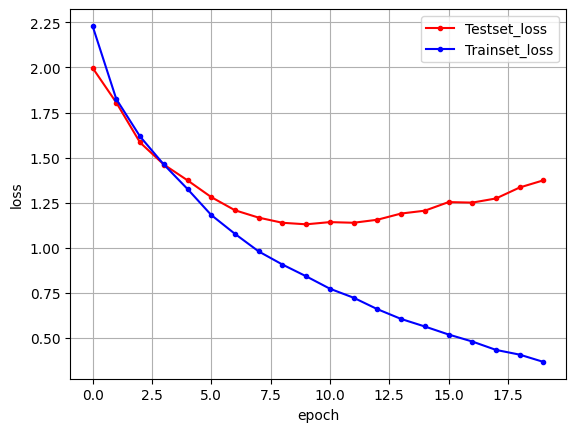

In [66]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

---



In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
# 웹사이트의 영화 리뷰
# 긍정(1) or 부정(0)
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

# 단어의 수를 맞추어 줍니다.
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

# 모델의 구조를 설정합니다.
model = Sequential([
    # tensorflow Input 사이즈 특징 : Input 데이터 크기 정하지 않아도 학습 가능
    # 즉, 첫 데이터에 따라 정해짐 -> 만약 값을 정하면 그거에 맞게 데이터를 넣어줘야함
    Input(shape=(None,)),
    Embedding(5000, 100),
    Dropout(0.5),
    # padding='valid' : padding을 하지 않겠다.
    Conv1D(64, 5, padding='valid', activation='relu', strides=1),   # CNN
    # 단, 자연어에서는 인코더 디코더가 feature를 더 잘 뽑을 수 있다.
    # CNN은 자연어, 이미지, 프레임에서 다 사용될 수 있다.
    MaxPooling1D(pool_size=4),
    LSTM(55),   # hidden size
    Dense(1),   # output size
    Activation('sigmoid')
])
model.summary()

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, None, 100)      │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, None, 64)       │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 55)             │        26,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 558,520 (2.13 MB)

 Trainable params: 558,520 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

### CNN 뒤에 LSTM을 둔 이유
> Conv1D를 먼저 두는 이유는 문장 속 국소 패턴(n-그램)을 빠르게 추출하고(예: 부정 표현, 강한 형용사 등), MaxPooling으로 시간 축을 압축해 노이즈를 줄이고 연산량을 크게 낮춘 뒤 그 순차적 특징열을 LSTM에 넘겨 장기 의존성과 순서 정보를 학습하게 하려는 설계이기 때문입니다. 이렇게 하면 LSTM이 처음부터 긴 시퀀스 전체를 처리하지 않아도 되어 학습이 더 안정적이고 빠르며, CNN이 잡은 국소 의미와 LSTM이 학습한 전역 문맥을 결합해 성능과 효율을 동시에 얻을 수 있습니다.

In [68]:
# 모델의 실행 옵션을 정합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=40, epochs=100, validation_split=0.25, callbacks=[early_stopping_callback])

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 101s 210ms/step - accuracy: 0.6958 - loss: 0.5369 - val_accuracy: 0.8874 - val_loss: 0.2734
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 134s 194ms/step - accuracy: 0.9056 - loss: 0.2440 - val_accuracy: 0.8709 - val_loss: 0.2975
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 139s 187ms/step - accuracy: 0.9305 - loss: 0.1840 - val_accuracy: 0.8907 - val_loss: 0.2711
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 147s 198ms/step - accuracy: 0.9526 - loss: 0.1379 - val_accuracy: 0.8896 - val_loss: 0.2794
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 144s 203ms/step - accuracy: 0.9652 - loss: 0.1050 - val_accuracy: 0.8899 - val_loss: 0.2917
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 101s 214ms/step - accuracy: 0.9718 - loss: 0.0854 - val_accuracy: 0.8880 - val_loss: 0.3496


In [69]:
# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.8781 - loss: 0.3778

 Test Accuracy: 0.8777


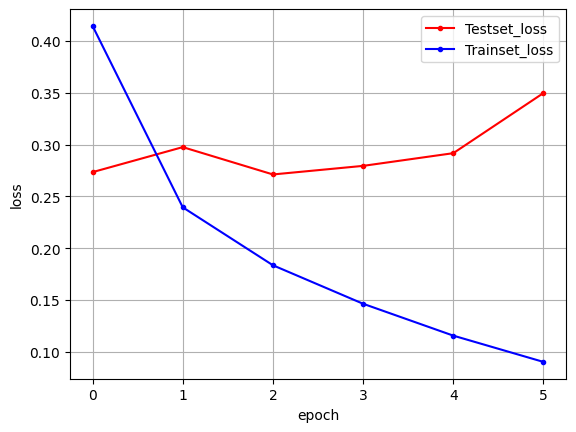

In [70]:
# 학습셋과 테스트셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()